In [0]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm # progress bar

import torch.backends.cudnn as cudnn # tuninig
from IPython.display import clear_output
import random 

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")     #Check whether a GPU is present.

In [14]:
device

device(type='cuda', index=0)

# Loading Data

## Model

In [0]:
class GeneratorNet(torch.nn.Module):
  
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.layer1 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.layer2 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.out(x)
        return x
    


## loading generators

In [0]:
generator_MNIST = GeneratorNet()

In [0]:
generator_FASHION = GeneratorNet()

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model_save_name = 'GAN_MNIST.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/{model_save_name}" 
checkpoint = torch.load(path)
generator_MNIST.load_state_dict(checkpoint['generator_state_dict'])
noise_MNIST = checkpoint["test_noise"]

In [0]:
model_save_name = 'GAN_FASHION.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/{model_save_name}" 
checkpoint = torch.load(path)
generator_FASHION.load_state_dict(checkpoint['generator_state_dict'])
noise_FASHION_MNIST = checkpoint["test_noise"]

In [0]:
with torch.no_grad():
    sample = Variable(torch.randn(16, 100))
    sample = (generator_MNIST(sample)+1)/2
    save_name = "sample_test.png"
    save_image(sample.view(16, 1, 28, 28),
              F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/results(class)/{save_name}")

In [20]:
sample.size()

torch.Size([16, 784])

# Model

In [0]:
# Writing our model
class Net(nn.Module):
    def __init__(self, number_classes):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=9),
            nn.ReLU(True),
            nn.Conv2d(6, 6, kernel_size=7),
            nn.ReLU(True),
            nn.Conv2d(6,6,kernel_size=5),
            nn.ReLU(True)
            )
        self.out = nn.Sequential(
            nn.Linear(600, number_classes, bias=True),
            nn.Softmax(dim=1)
        )
        
    def forward(self,x):
        x = self.conv(x).view(x.size()[0],600)
        x = self.out(x)
        return x

# Generation

In [0]:
def generate(quant=16):
  samples = []
  with torch.no_grad():
    sample = Variable(torch.randn(quant, 100))
    mnist = generator_MNIST(sample).view(quant, 1, 28, 28)
    
    for im in mnist:
      samples.append([0,im])

    sample = Variable(torch.randn(quant, 100))
    fashion = generator_FASHION(sample).view(quant, 1, 28, 28)

    for im in fashion:
      samples.append([1,im])

    random.shuffle(samples)

    targets = torch.LongTensor([row[0] for row in samples])
    x = torch.Tensor()
    for row in samples:
      x = torch.cat((x, row[1]), 0)

  return (targets, x.view(2*quant,1,28,28))

In [178]:
generate(16)[0]


tensor([1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 1])

# Train

In [0]:
num_epochs = 5 

train_loss = []
classificator = Net(2)
criterion = nn.NLLLoss() 
optimizer = torch.optim.Adam(classificator.parameters(), weight_decay=1e-5,)

In [0]:
classificator.to(device)
if device.type == 'cuda':
    classificator = torch.nn.DataParallel(classificator)
    cudnn.benchmark = True

In [0]:
def train(epoch, size=1000):
    print('\nEpoch: %d' % epoch)
    classificator.train()
    loss = 0
    correct = 0
    total = 0

    for step in tqdm(range(size)):
        step += 1
        targets, inputs  = generate(16)
        inputs, targets  = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = classificator(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss.append(loss/(step+1))
    print('Loss: {0:3f} | Acc: {1:3f} ({2:d}/{3:d})'.format(loss/(step+1), 100.*correct/total, correct, total))

# Test

In [0]:

def test(epoch, model, test_sample):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        
        data = test_sample.to(device)
        recon_batch = model(data)
        test_loss += distance(recon_batch, data)


        n = min(data.size(0), 8)
        comparison = torch.cat([data[:n],
                              recon_batch.view(16, 1, 28, 28)[:n]])
        save_name = "reconstruction_" + str(epoch) + ".png"
        save_image(comparison.cpu(),
                  F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/results(VAE)/{save_name}", nrow=n)

    test_loss /= 16
    print('Test set loss: {:.4f}'.format(test_loss))


In [0]:
test(0, model_MNIST, generator_MNIST(Variable(torch.randn(16, 100)).to(device)).view(16,1,28,28))

====> Test set loss: 0.0136


In [0]:
torch.randn(16, 100)

tensor([[ 0.7271, -0.7713,  0.6787,  ..., -0.1858, -1.4053, -0.6718],
        [-0.4202,  2.1304, -0.1957,  ..., -0.3573, -0.5275,  1.1167],
        [ 0.8207,  0.4842, -0.0485,  ...,  1.5150, -1.4400, -0.2378],
        ...,
        [-2.2543,  3.2895, -0.6443,  ...,  1.5207,  1.1420, -1.9610],
        [ 0.5869,  1.4795, -1.1248,  ..., -1.5866,  0.2303,  0.5621],
        [ 1.4451, -0.2212, -1.1403,  ...,  0.3650, -0.7877,  2.3553]])

# Main


In [0]:
# test_sample = generator_MNIST(noise_MNIST).view(16,1,28,28)
epoch = 0


In [193]:
for i in range(1, 60):
    epoch += 1
    train(epoch)
    # test(epoch, model_MNIST, test_sample)
    if i%10 == 0:
      clear_output()
       


Epoch: 51



Loss: -0.001998 | Acc: 99.812500 (31940/32000)

Epoch: 52



Loss: -0.001998 | Acc: 98.103125 (31393/32000)

Epoch: 53



Loss: -0.001936 | Acc: 99.815625 (31941/32000)

Epoch: 54



Loss: -0.001936 | Acc: 99.853125 (31953/32000)

Epoch: 56



Loss: -0.001998 | Acc: 99.878125 (31961/32000)

Epoch: 57



Loss: -0.001998 | Acc: 99.828125 (31945/32000)

Epoch: 58



Loss: -0.001998 | Acc: 98.884375 (31643/32000)

Epoch: 59



Loss: -0.001998 | Acc: 99.693750 (31902/32000)


# Check

In [0]:
classes = ["Digit","Clothes"]

tensor([1., 0.])
tensor([0., 1.])
tensor([1., 0.])
tensor([0., 1.])
tensor([1., 0.])
tensor([0., 1.])
tensor([0., 1.])
tensor([1., 0.])
tensor([1., 0.])
tensor([1., 0.])
tensor([0., 1.])
tensor([1., 0.])
tensor([0., 1.])
tensor([0., 1.])
tensor([1., 0.])
tensor([1., 0.])
tensor([0., 1.])
tensor([0., 1.])
tensor([1., 0.])
tensor([1., 0.])
tensor([0., 1.])
tensor([1., 0.])
tensor([0., 1.])
tensor([0., 1.])


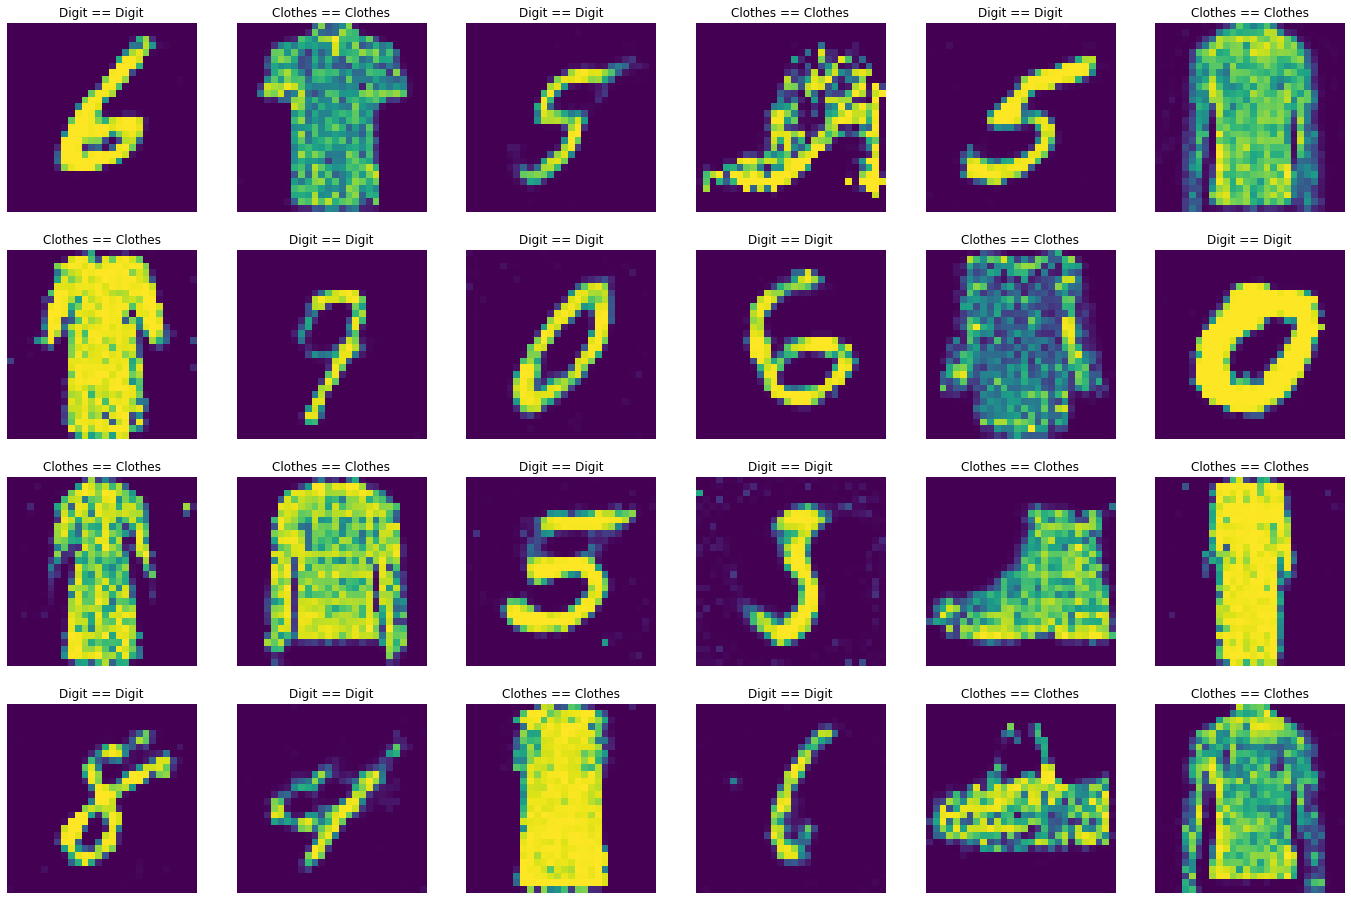

In [215]:
labels, samples = generate(12)
samples = samples.to(device)

fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
with torch.no_grad():
  output = classificator(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    print(output[num].cpu())
    plt.title(classes[labels[num]] + " == " + classes[pred[num]] )
    plt.axis('off')
    sample = sample.cpu().numpy()

    plt.imshow((sample[0]+1)/2) # np.transpose(sample, (1,2,0))

# Saving

In [194]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
model_save_name = 'Classificator.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/{model_save_name}" 
torch.save({
    'model_state_dict': classificator.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch
    }, path)

In [0]:
model_save_name = 'Classificator.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/ComputerVision/MNIST/{model_save_name}" 
checkpoint = torch.load(path)
classificator.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']


# References

https://www.kaggle.com/pintu161/transfer-learning-in-pytorch-using-resnet18     very useful

https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py

https://github.com/townblack/pytorch-cifar10-resnet18/blob/master/train.py

https://github.com/kuangliu/pytorch-cifar/blob/master/main.py